# Objectives

1. Plot RTT: Regression
1. Plot Rate Variation: Histogram
1. Plot Timetree: Phylo
1. Plot Divtree: Phylo
1. Plot Marginal Distribution: Violin

---
# Setup

## Import Modules

In [1]:
import os
import copy

import seaborn as sns
import matplotlib.pyplot as plt

import random
import json # Read clock model data
import scipy.stats # Regression line
import math

from Bio import Phylo

import dill
from treetime.treetime import plot_vs_years

## Input File Paths

In [2]:
# jupyter notebook output
tree_df_dill = "../../results/clock_model/clock_model.df.obj"
tree_dill = "../../results/clock_model/clock_model.treetime.obj"
augur_json = "../../results/clock_model/clock_model_augur.json"

outdir = "../../results/clock_model/"

# Create output directory if it doesn't exist
if not os.path.exists(outdir):
    os.mkdir(outdir)

## Variables

In [3]:
from config import *

NAME_COL = "Name"
SCRIPT_NAME = "clock_model"

plt.rc('lines', linewidth=2)
plt.rc('legend', labelspacing=0.75)
plt.rc('legend', frameon=False) # legend frame

sns.set_style("ticks")

## Import Dataframe

In [4]:
with open(tree_df_dill, "rb") as infile:
    tree_df = dill.load(infile)
tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number,timetree_rate,timetree_rate_fold_change,timetree_mutation_length,timetree_raw_date,timetree_num_date,timetree_num_date_confidence,timetree_num_date_bar,timetree_clock_length,timetree_coord_x,timetree_coord_y,timetree_reg_x,timetree_reg_y,timetree_reg_bad
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NODE0,100,NA,0,black,0,17.8205,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,9.263554e-09,1.000000,2.148815e-07,-4000-09-21,-3999.277481,"[-4114.0959399021, -3791.54718956593]","[6135.0959399021, 5812.54718956593]",0.100000,0.100000,16.189335,-3999.277481,0.000000,False
SAMEA3541827,NA,NA,3.8504e-06,grey,3.8504e-06,1,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0,2.800384e-09,0.302301,3.224947e-06,-2881-08-02,-2880.414384,"[-2875.9999999999995, -2676.9999999999995]","[4897.0, 4698.0]",1118.863097,1118.963097,1.000000,-2776.500000,0.000003,False
NODE1,100,85,1.32708e-05,black,1.32708e-05,3.15625,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.185209e-08,1.279433,8.176386e-06,-3356-01-28,-3355.925187,"[-3424.5669580911117, -3154.7902001929688]","[5445.566958091112, 5175.790200192969]",643.352294,643.452294,3.156250,-3355.925187,0.000008,False
SAMEA104233046,NA,NA,2.2484e-06,grey,1.55192e-05,2,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0,2.591999e-09,0.279806,2.150201e-06,-2617-08-21,-2616.363588,"[-2620.9999999999995, -2471.9999999999995]","[4642.0, 4493.0]",739.561600,1383.013893,2.000000,-2546.500000,0.000010,False
NODE2,100,94.6,1.36364e-05,black,2.69072e-05,4.3125,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.987130e-08,2.145105,1.443313e-05,-2652-12-16,-2651.043091,"[-2740.0327670266406, -2561.2954874168845]","[4761.032767026641, 4582.2954874168845]",704.882097,1348.334390,4.312500,-2651.043091,0.000023,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE_0000360,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,8.949873e-09,0.966138,1.779610e-21,1953-12-09,1953.939572,"[1926.3366503317973, 1954.0]","[94.66334966820273, 67.0]",1.314338,5953.317053,541.500000,1953.939572,0.000065,False
NODE_0000453,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,9.263554e-09,1.000000,1.794170e-21,1965-12-13,1965.950389,"[1796.8701895964089, 1966.0]","[224.12981040359114, 55.0]",72.181182,5965.327870,554.500000,1965.950389,0.000064,False
NODE_0000477,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,9.263554e-09,1.000000,1.732455e-21,1982-12-05,1982.928648,"[1973.680015930341, 1987.6535919453909]","[47.319984069659085, 33.34640805460913]",15.314673,5982.306129,592.875000,1982.928648,0.000068,False


## Import Tree

In [5]:
with open(tree_dill, "rb") as infile:
    tt = dill.load(infile)
tt.tree.ladderize(reverse=False)

In [6]:
tt.clock_model

{'slope': 9.263553689093914e-09,
 'intercept': 4.1323189775189253e-05,
 'chisq': 665.4293045834199,
 'hessian': array([[ 7.52787426e+18, -8.63719505e+14],
        [-8.63719505e+14,  7.35486166e+11]]),
 'cov': array([[1.53525788e-19, 1.80293286e-16],
        [1.80293286e-16, 1.57137263e-12]]),
 'r_val': 0.5463137949533817,
 'valid_confidence': True}

---
# 1. Plot RTT: Regression

/home/ktmeaton/miniconda3/envs/plague-phylogeography/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


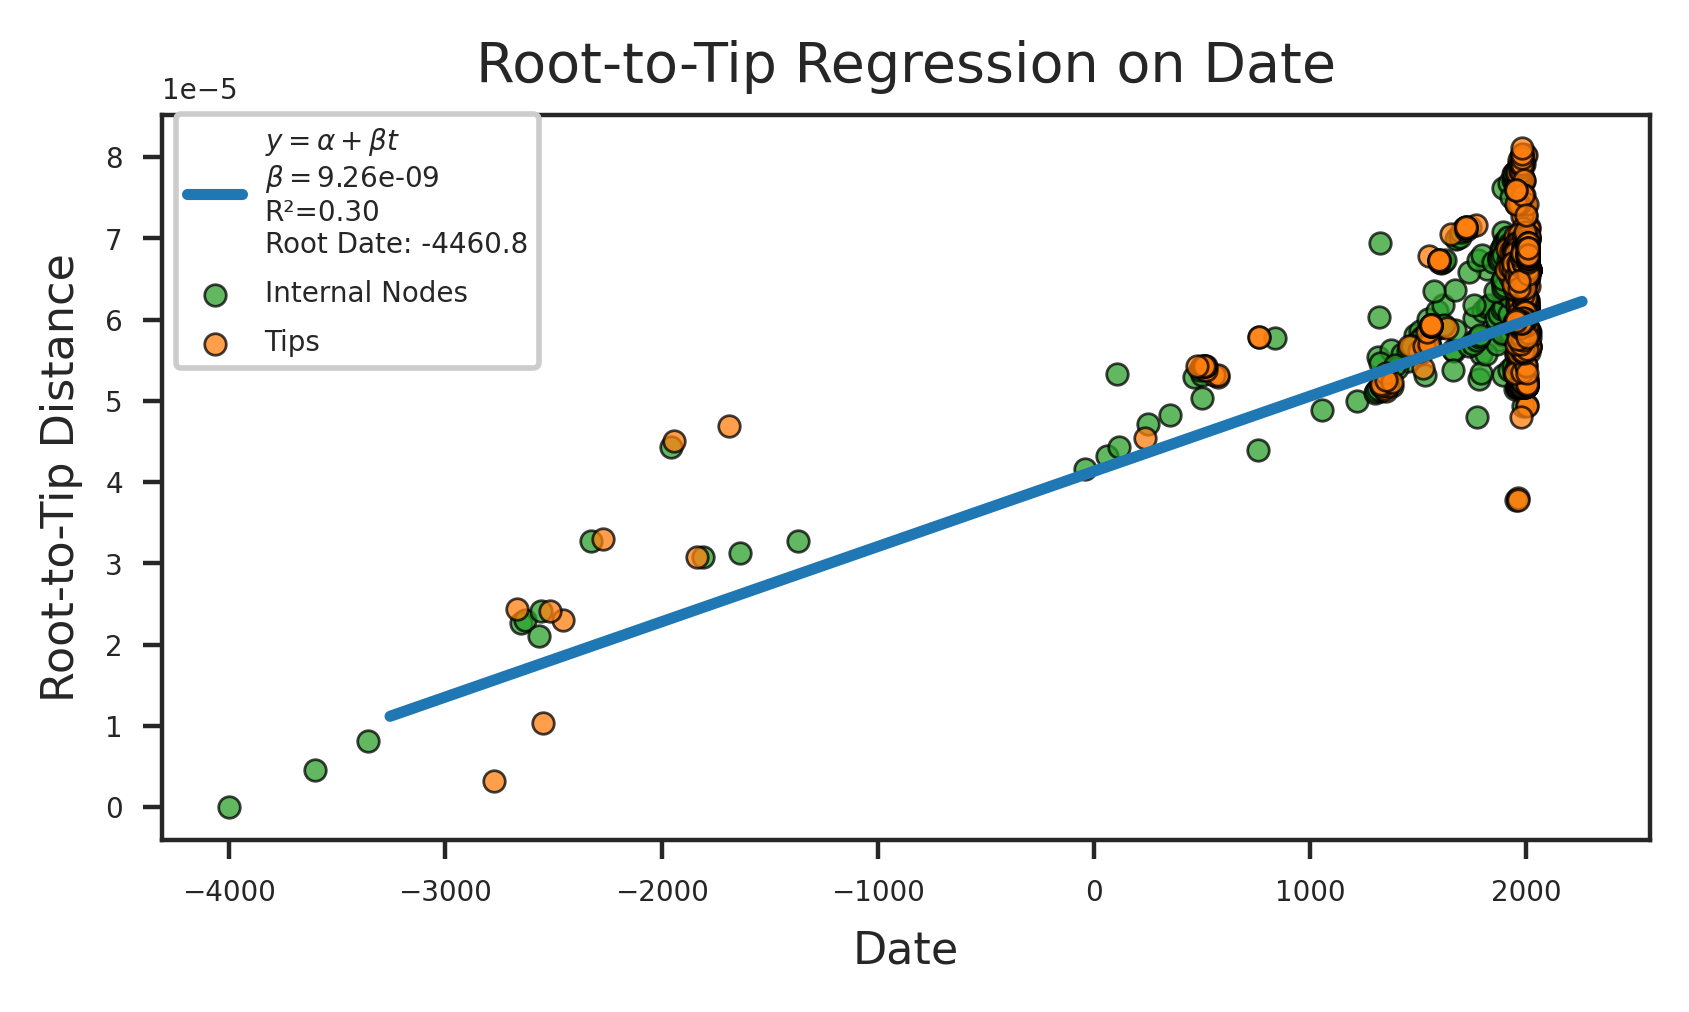

In [7]:
regression = tt.clock_model

# Setup axis
fig, (ax1) = plt.subplots(1, dpi=dpi, figsize=figsize_mini)


# Make separate datasets for tips and internal nodes
tip_data = tree_df[(tree_df["timetree_reg_x"] != NO_DATA_CHAR) &
                   (tree_df["Branch_Support_Color"] == TERM_COL) ]

int_data = tree_df[(tree_df["timetree_reg_x"] != NO_DATA_CHAR) & (tree_df["Branch_Support_Color"] != TERM_COL)]

# Time to most recent common ancestor (x-intercept)
t_mrca = -regression['intercept']/regression['slope']

# This does not filter for bad branches!
time_span = np.max(tip_data["timetree_reg_x"]) - np.min(tip_data["timetree_reg_x"])
x_vals = np.array([max(np.min(tip_data["timetree_reg_x"]), t_mrca) - 0.1*time_span, 
                   np.max(tip_data["timetree_reg_x"]+0.05*time_span)])

res = scipy.stats.linregress(list(tip_data["timetree_reg_x"]),list(tip_data["timetree_reg_y"]))

# When no confidence is enabled
dev_rtt = None
dev_slope = None

# Plot internal nodes
ax1.scatter(data=int_data, 
            x="timetree_reg_x", 
            y="timetree_reg_y",
            label="Internal Nodes",
            color=DISC_CMAPLIST[2],
            edgecolor="black",
            linewidth=0.5,
            s=15,
            alpha=0.75,
            zorder=1,)
# Plot tips
ax1.scatter(data=tip_data, 
            x="timetree_reg_x", 
            y="timetree_reg_y",
            label="Tips",
            color=DISC_CMAPLIST[1],
            edgecolor="black",
            linewidth=0.5,
            s=15,
            alpha=0.75,
            zorder=2,)

# Regression line
ax1.plot(x_vals, 
         regression['slope']*x_vals + regression['intercept'],
         label = r"$y=\alpha + \beta t$"+"\n"+
                r"$\beta=$%1.2e"%(regression["slope"])
                + ("+/- %1.e"%dev_slope if dev_slope else "") +
                "\nR²={:.2f}".format(res.rvalue**2) +
                "\nRoot Date: %1.1f"%(-regression['intercept']/regression['slope']) +
                ("+/- %1.2f"%dev_rtt if dev_rtt else ""),
         color=DISC_CMAPLIST[0],
         zorder=3,
        )

# Labels
ax1.set_xlabel("Date")
ax1.set_ylabel("Root-to-Tip Distance")
ax1.set_title("Root-to-Tip Regression on Date")
# Legend
#plt.legend(loc=2, frameon = 1, framealpha=1)
plt.legend(bbox_to_anchor=(0,1.02), 
           loc="upper left",
           frameon = 1, 
           framealpha=1)

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_rtt." + FMT) 
plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

---
# 2. Plot Rate Variation: Histogram

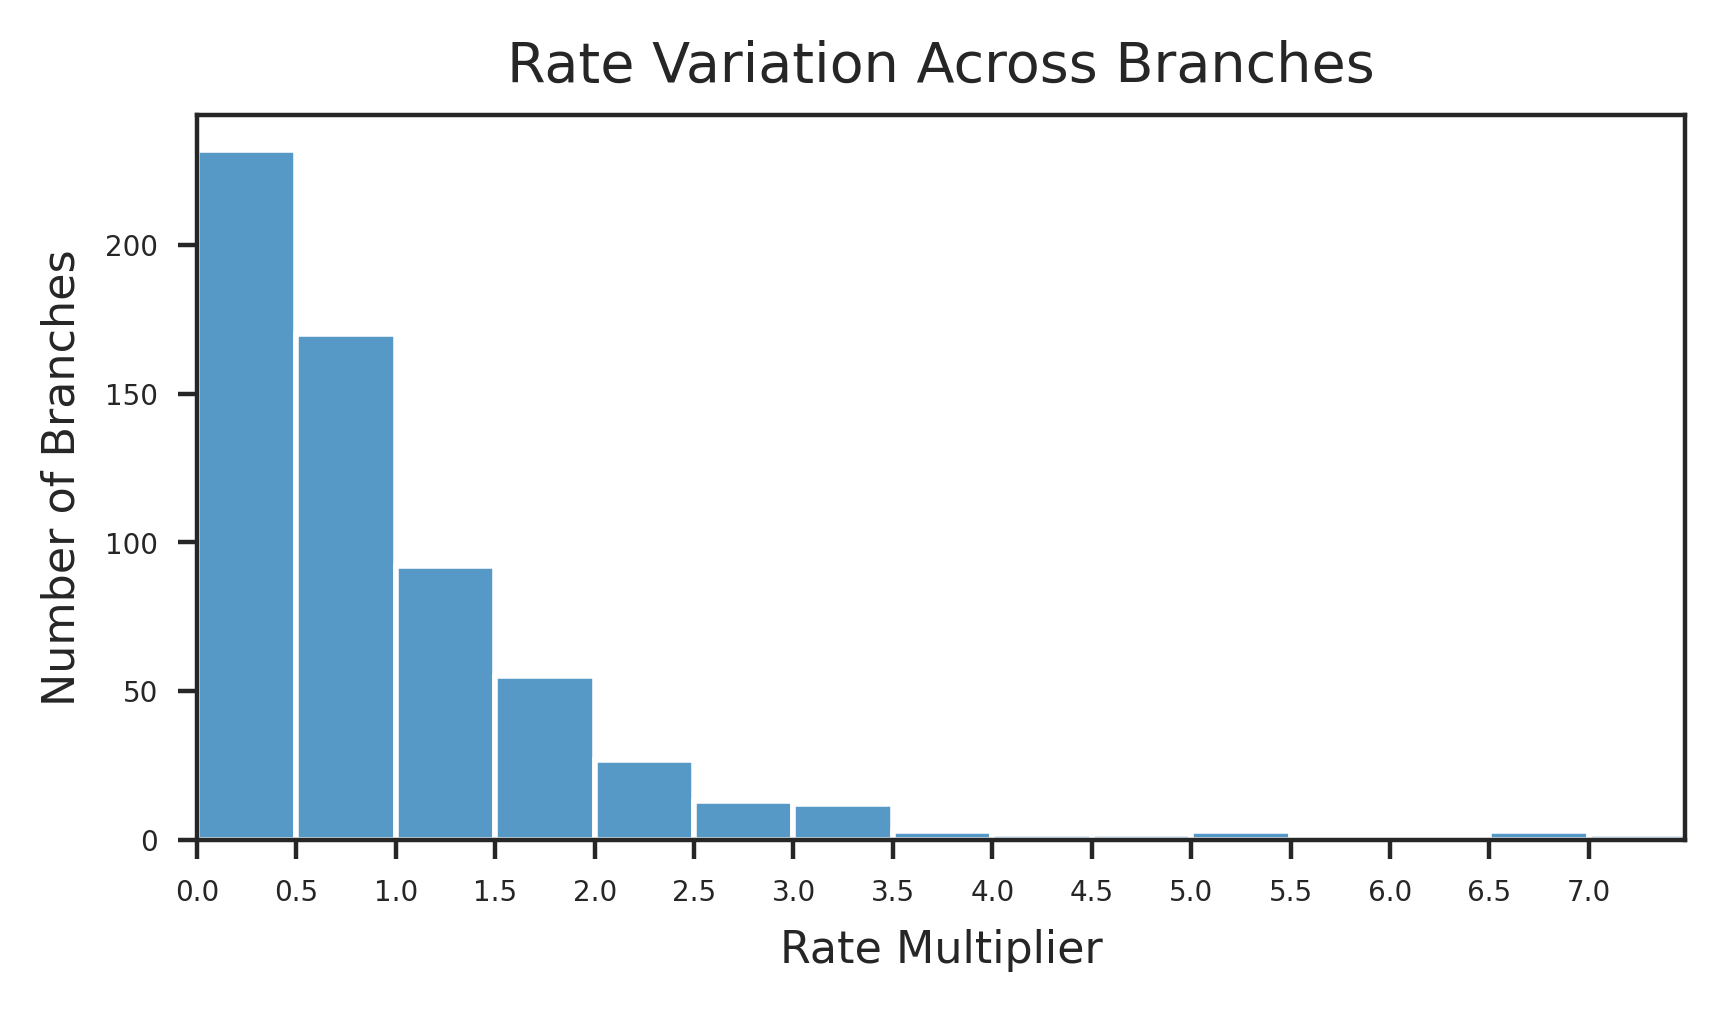

In [8]:
# Setup axis
fig, ax1 = plt.subplots(1, dpi=dpi, figsize=figsize_mini)

# Plot the histogram
# troubleshoot the disappearing nodes!

min_gamma = ['', 1]
max_gamma = ['', 1]
gamma_dict = {}
    
for rec in tip_data.iterrows():
    sample = rec[0]
    data = rec[1]
    g = tip_data["timetree_rate_fold_change"][sample]
    if g <= min_gamma[1]:
        min_gamma[0] = sample
        min_gamma[1] = g
    if g >= max_gamma[1]:
        max_gamma[0] = sample
        max_gamma[1] = g
    gamma_dict[sample] = g

# Check if there's no rate variation
if min_gamma[1] == 1 and max_gamma[1] == 1:
    hist_bins=1
    ax1.set_xticks([1.0])
else:
    int_max_gamma = math.ceil(max_gamma[1])
    hist_bins = [x/10 for x in range(0,int_max_gamma * 10, 5)]
    xticks_major = [x/10 for x in range(0, int_max_gamma * 10, 5)]
    ax1.set_xticks(xticks_major)
    ax1.set_xlim(0,max_gamma[1])

sns.histplot(x = list(gamma_dict.values()), 
         ax=ax1,
         alpha=0.75,
         bins=hist_bins,
         ) 

ax1.set_xlabel("Rate Multiplier")
ax1.set_ylabel("Number of Branches")
ax1.set_title("Rate Variation Across Branches")

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_rate-variation." + FMT) 
plt.savefig(out_path, 
        dpi=dpi, 
        bbox_inches = "tight")

# 3. Plot Timetree: Phylo

2622.25	--ClockTree.branch_length_to_years: setting node positions in units of
       	  years


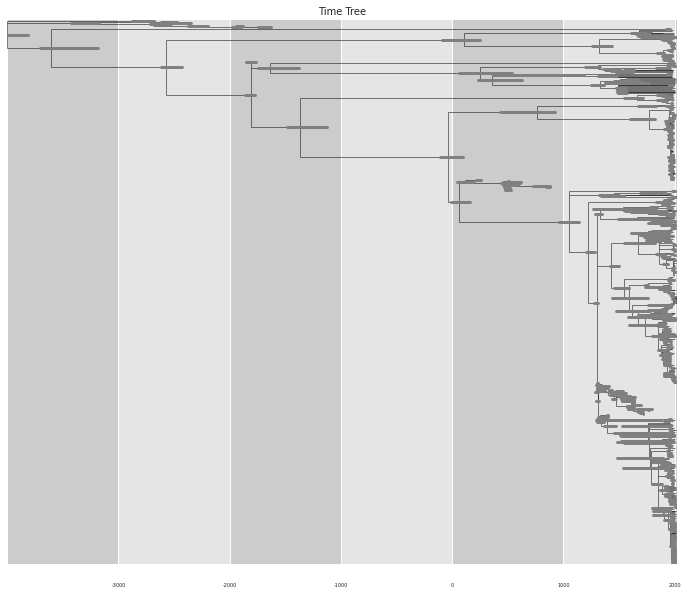

In [9]:
tt_copy = copy.deepcopy(tt)

# Setup plot
plt.rc("lines", linewidth=0.5)
#DIV = 10
#STEP = (CURRENT_YEAR - tt_copy.tree.root.numdate) / DIV
#STEP = round(STEP, -3)

if hasattr(tt.tree.root, "marginal_inverse_cdf"):
    fig, ax1 = plot_vs_years(tt_copy,
                             #step=STEP,  
                             confidence=(1.0-CONFIDENCE,CONFIDENCE), 
                             label_func = lambda x:"",
                             do_show=False)
else:
    fig, ax1 = plot_vs_years(tt_copy,
                             #step=STEP,  
                             label_func = lambda x:"",
                             do_show=False)

ax1.set_title("Time Tree", fontsize=LG_FONT)

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_timetree-default." + FMT) 
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")


## Manual

3541.81	--ClockTree.branch_length_to_years: setting node positions in units of
       	  years


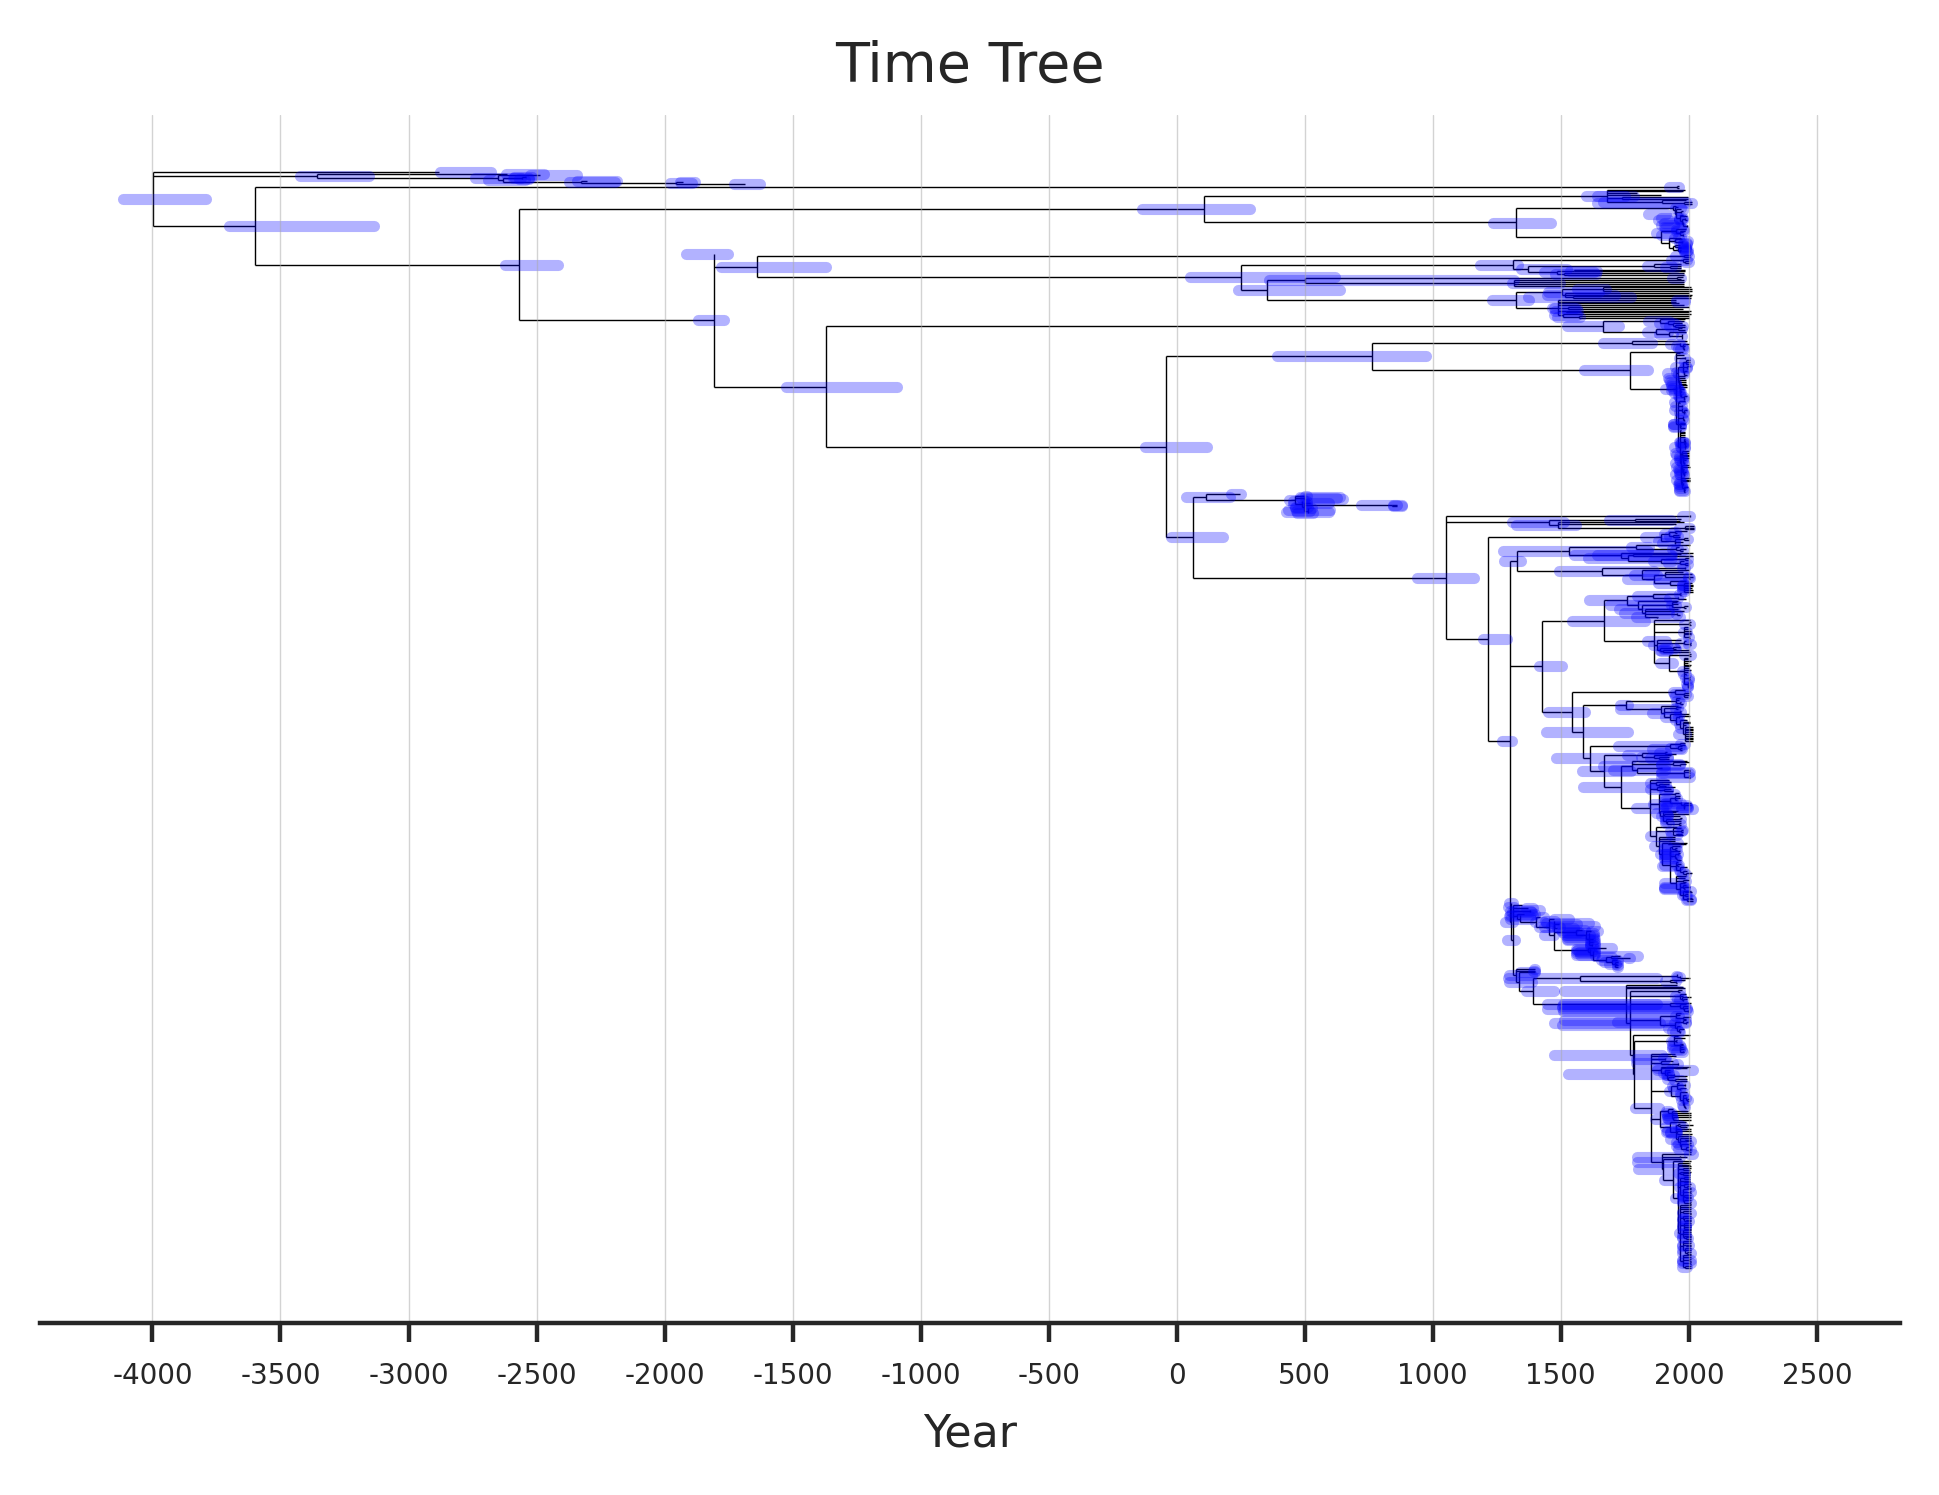

In [63]:
# --------------------------------------------
# Setup
plt.rc("lines", linewidth=0.25)
fig, ax1 = plt.subplots(1, dpi=dpi)

# --------------------------------------------
# Data
tt_copy.branch_length_to_years()

# reset color
for c in tt_copy.tree.find_clades():
    c.color = "black"
Phylo.draw(tt_copy.tree,
           axes=ax1, 
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False)


# --------------------------------------------
# Ticks
ticks_dict = convert_timetree_ticks(tree=tt_copy.tree, step=500)
# Set the new tick locations and labels
ax1.set_xticks(ticks_dict["tick_locs"])
ax1.set_xticklabels(ticks_dict["tick_labels"])
date_to_x = float(ticks_dict["tick_locs"][-1]) - float(ticks_dict["tick_labels"][-1])

x_min = 0
if hasattr(tt_copy.tree.root, "marginal_inverse_cdf"):
    # Need to invert the node bar units
    present_date = abs(tt_copy.tree.root.numdate - CURRENT_YEAR)
    for rec in tree_df.iterrows():
        conf_bar = rec[1]["timetree_num_date_bar"]
        bar_lower = present_date - conf_bar[0]
        bar_upper = present_date - conf_bar[1]
        y = rec[1]["timetree_coord_y"]
        ax1.plot([bar_lower, bar_upper], [y,y], alpha=0.3, c="blue", linewidth=2)
        
        # Possibly update axis x-limits
        if bar_lower < x_min:
            x_min = bar_lower
        

# --------------------------------------------
# Lines
# Vertical lines for dates
for loc in ticks_dict["tick_locs"]:
    ax1.axvline(x=loc, color="darkgrey", alpha=0.5)

# --------------------------------------------
# Labels
ax1.set_xlabel("Year")
ax1.set_ylabel("")
ax1.set_yticks([])
plt.title("Time Tree")

# --------------------------------------------
# Limits
x_buffer = math.ceil((ticks_dict["tick_locs"][-1] - ticks_dict["tick_locs"][0]) * 0.05)
y_buffer = math.ceil(len(tt_copy.tree.get_terminals()) * 0.05)

#ax1.set_xlim(ticks_dict["tick_locs"][0], ticks_dict["tick_locs"][-1] + x_buffer)
ax1.set_xlim(x_min - x_buffer, ticks_dict["tick_locs"][-1] + x_buffer)
ax1.set_ylim(len(tt_copy.tree.get_terminals()) + y_buffer, 0 - y_buffer)

# --------------------------------------------
# Misc
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["left"].set_visible(False)

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_timetree." + FMT) 
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

# 4. Plot Divtree: Phylo

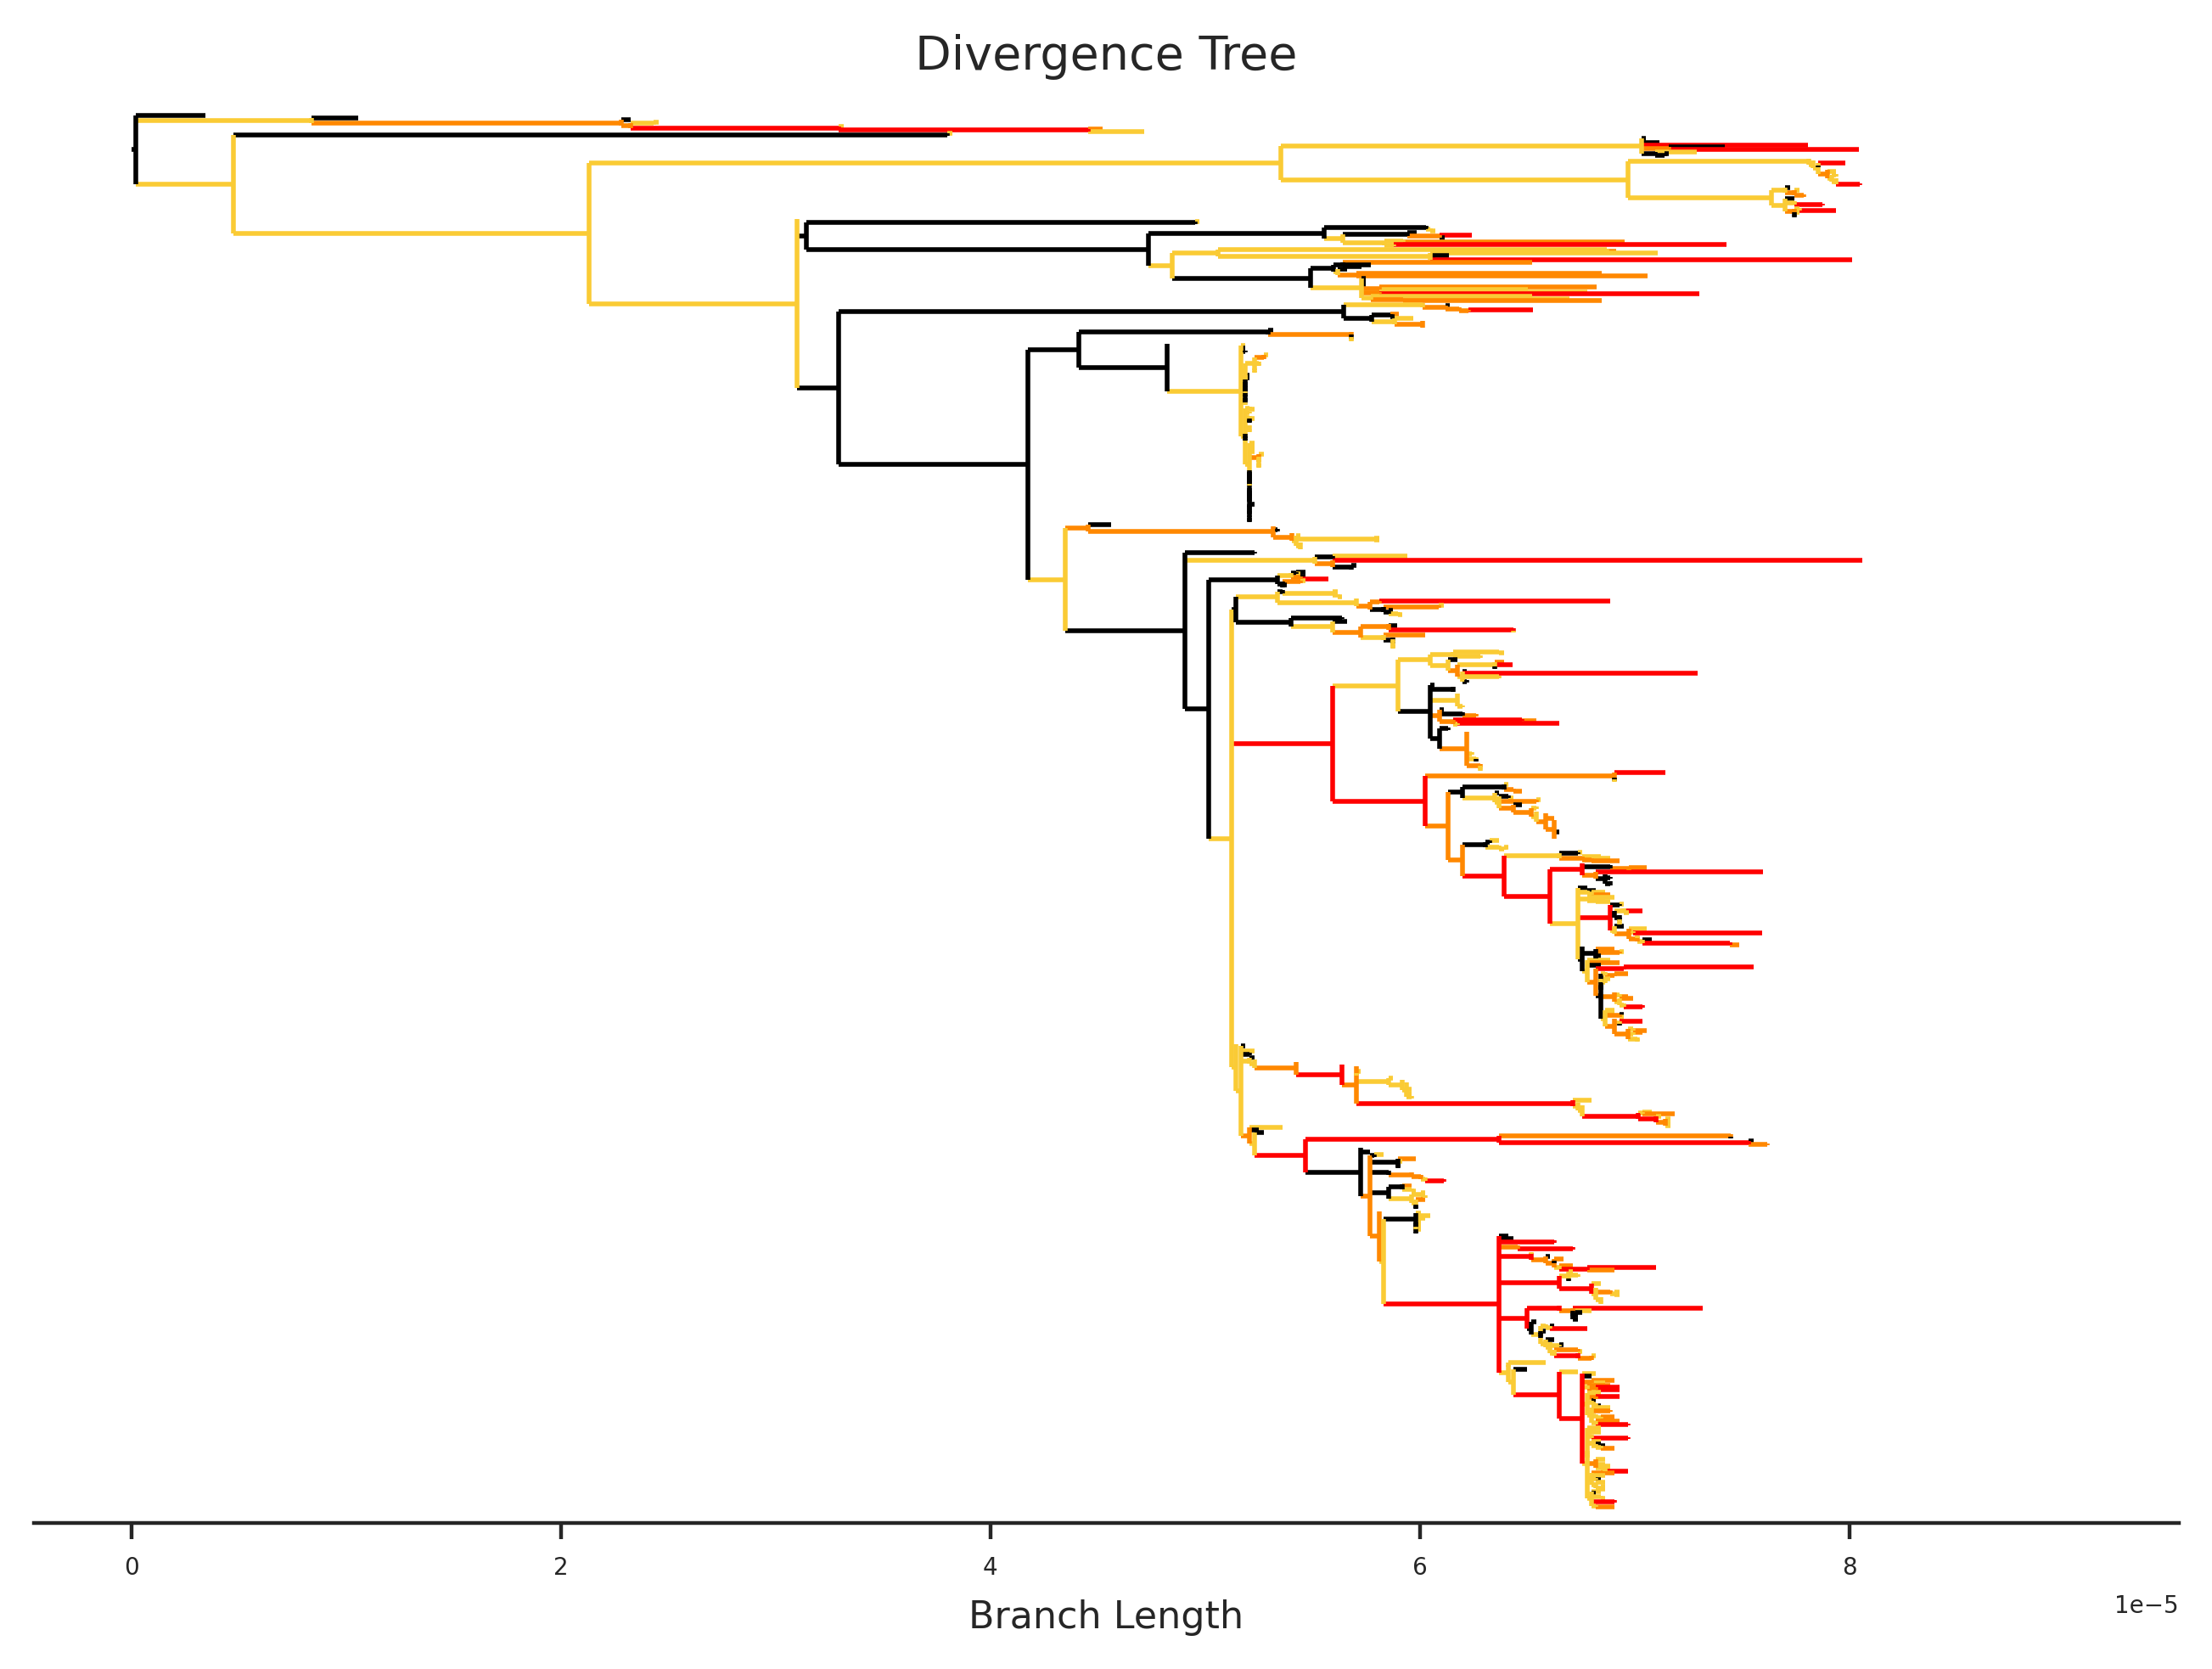

In [64]:
# Set branch length to mutations
for n in tt_copy.tree.find_clades():
    n.branch_length=n.mutation_length
    
min_gamma = min(tree_df["timetree_rate_fold_change"])
max_gamma = max(tree_df["timetree_rate_fold_change"])
gamma_range = max_gamma - min_gamma

GAMMA_COL_PAL = {
    0: "#000000", # black
    1: "#facb35", # yellow
    2: "#ff8800", # orange
    3: "#ff0000"} # red

for c in tt_copy.tree.find_clades():
    if not hasattr(c.branch_length_interpolator, "gamma"):
        c.color = GAMMA_COL_PAL[0]
        continue
    gamma = c.branch_length_interpolator.gamma
    # Switch Case
    if gamma >= 0 and gamma < 1:
        c.color = GAMMA_COL_PAL[0]
    elif gamma >= 1 and gamma < 2:
        c.color = GAMMA_COL_PAL[1]    
    elif gamma >= 2 and gamma < 3:
        c.color = GAMMA_COL_PAL[2]     
    elif gamma >= 3:
        c.color = GAMMA_COL_PAL[3] 

# Setup plot
plt.rc("lines", linewidth=1)
fig, ax1 = plt.subplots(1, dpi=dpi, figsize=figsize, constrained_layout=True,)

Phylo.draw(tt_copy.tree,
           axes=ax1, 
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False)

# --------------------------------------------
# Lines
# Vertical lines for dates
for loc in ticks_dict["tick_locs"]:
    ax1.axvline(x=loc, color="darkgrey", alpha=0.5)

# --------------------------------------------
# Labels
ax1.set_xlabel("Branch Length")
ax1.set_ylabel("")
ax1.set_yticks([])
plt.title("Divergence Tree")

# --------------------------------------------
# Limits
coord_x = [x for x in tree_df["coord_x"] if x != NO_DATA_CHAR]
x_buffer = max(coord_x) * 0.05
y_buffer = math.ceil(len(tt_copy.tree.get_terminals()) * 0.01)

ax1.set_xlim(0 - x_buffer, max(coord_x) + x_buffer)
ax1.set_ylim(len(tt_copy.tree.get_terminals()) + y_buffer, 0 - y_buffer)

# --------------------------------------------
# Misc
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["left"].set_visible(False)

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_divtree-rate." + FMT) 
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

## Demo

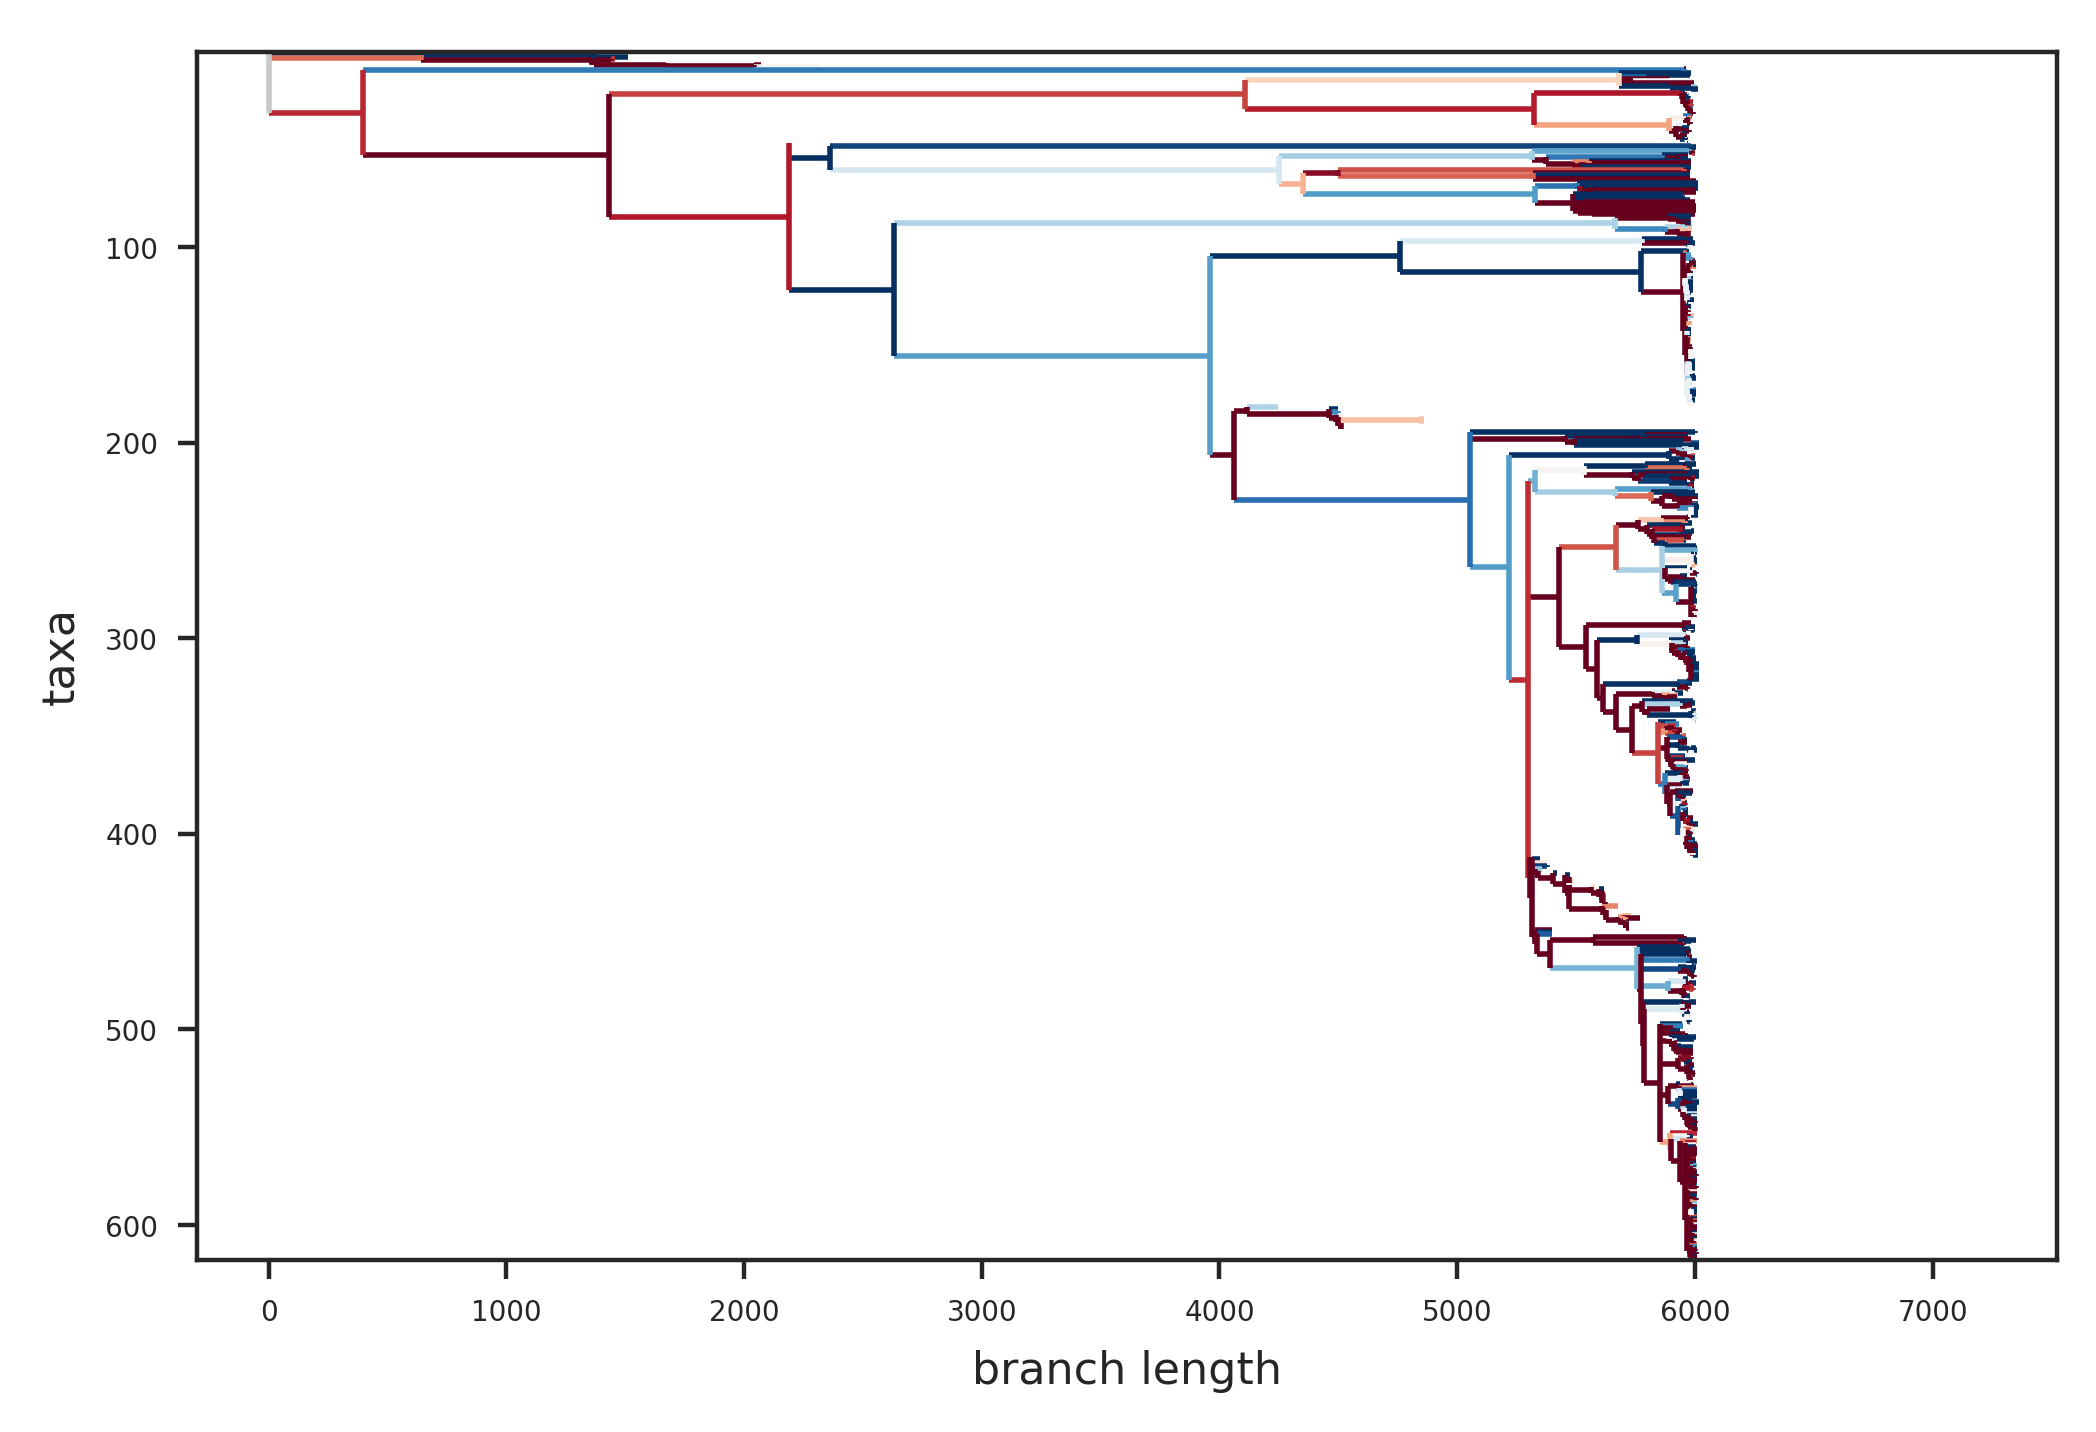

Text(0.5, 1.0, 'Rate Variation')

In [65]:
from matplotlib import cm
tt_copy = copy.deepcopy(tt)

fig, ax1 = plt.subplots(1, dpi=dpi)
vmin, vmax = 0.5, 1.5 # color branches according to the rate deviation
for n in tt_copy.tree.find_clades():
    if n.up:
        n.color = [int(x*255) for x in cm.RdBu_r((min(max(vmin, n.branch_length_interpolator.gamma),vmax)-vmin)/(vmax-vmin))[:3]]
    else:
        n.color = [200,200,200]

Phylo.draw(tt_copy.tree, 
           axes=ax1, 
           show_confidence=False, 
           label_func = lambda x:'')

ax1.set_title("Rate Variation")